In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

import random
import pickle
import seaborn as sns
sns.set()

from copy import deepcopy
import datetime
from haversine import haversine

import warnings;warnings.simplefilter('ignore')

In [2]:
class chromosome:
    """
    Class to build chromosome specified for TSP problem. It makes use 
    of pandas dataframe to keep the locations (latitudes, logitudes)
    and their order.
    """
    def __init__(self, locations):
        self.df = pd.DataFrame(columns=['x','y'])
        for location in locations:
            self.df = self.df.append(location, ignore_index=True)
            
    def Shuffle(self, order=None):
        """
        shuffle the dataframe if the order is not given
        """
        if not order:
            order = self.Path()
            random.shuffle(order)
        self.df = self.df.reindex(order)
    
    def Path(self):
        """
        returns the order of visiting locations
        """
        return self.df.index.tolist()
    
    def CrossOver_1(self):
        """
        Substitute elements pairwise from begining 
        """
        order = self.Path()
        for i in range(1,len(order)):
            if (i%2 == 1):
                order[i], order[i-1] = order[i-1], order[i]
        self.Shuffle(order)
    
    def CrossOver_2(self):
        """
        Split total path into two parts, then replace them with each other
        """
        order = self.Path()
        middle = int(len(order)/2)
        for i in range(middle):
            order[i], order[i+middle] = order[i+middle], order[i]
        self.Shuffle(order)
    
    def Mutate(self, n_mut):
        """
        Selects random locations from path and substitute them with
        each other
        """
        order = self.Path()
        mutated = random.choices(order, k=n_mut)
        for i in range(len(mutated)):
            if i%2==0:
                order[mutated[i]], order[mutated[i+1]] = order[mutated[i+1]], order[mutated[i]]
        self.Shuffle(order)
        
    def Fitness(self):
        """
        Calculates the total cost of traveling through whole path
        """
        passenger_count=1
        store_and_fwd_flag=0
        date_list = [27, 5, 2016]
        year = int(date_list[2])
        month = int(date_list[1])
        day = int(date_list[0])
        my_date = datetime.date(year, month, day)
        
        data = []
        for  index in range(1,self.df.shape[0]):
            p_x = self.df.x.iloc[index-1]
            p_y = self.df.y.iloc[index-1]
            
            d_x = self.df.x.iloc[index]
            d_y = self.df.y.iloc[index]
            
            model_data = {
                    'passenger_count': passenger_count,
                    'pickup_longitude': p_x,
                    'pickup_latitude': p_y,
                    'dropoff_longitude': d_x,
                    'dropoff_latitude': d_y,
                    'store_and_fwd_flag': bool(store_and_fwd_flag),
                    'pickup_month': my_date.month,
                    'pickup_day': my_date.day,
                    'pickup_weekday': my_date.weekday(),
                    'pickup_hour': 11,
                    'pickup_minute': 0,
                    'latitude_difference': p_x - d_x,
                    'longitude_difference': p_y - d_y,
                    'distance': haversine((p_x,p_y), (d_x, d_y))
                    }
            data.append(model_data)
                
        p_x = self.df.x.iloc[-1]
        p_y = self.df.y.iloc[-1]

        d_x = self.df.x.iloc[0]
        d_y = self.df.y.iloc[0]
        model_data = {
            'passenger_count': passenger_count,
            'pickup_longitude': p_x,
            'pickup_latitude': p_y,
            'dropoff_longitude': d_x,
            'dropoff_latitude': d_y,
            'store_and_fwd_flag': bool(store_and_fwd_flag),
            'pickup_month': my_date.month,
            'pickup_day': my_date.day,
            'pickup_weekday': my_date.weekday(),
            'pickup_hour': 11,
            'pickup_minute': 0,
            'latitude_difference': p_x - d_x,
            'longitude_difference': p_y - d_y,
            'distance': haversine((p_x,p_y), (d_x, d_y)),
        }
        data.append(model_data)
        
        df = pd.DataFrame(data, columns=model_data.keys())
        preds = np.exp(xgb_model.predict(xgb.DMatrix(df))) - 1
        return preds.sum()
    
    def Plot(self):
        """
        Ploting the traveling path according to visiting order of locations.
        """
        plt.figure(figsize=(10,10))
        ax = self.df.plot.scatter('x', 'y', title='TOTAL PATH='+str(self.Path()), figsize=(8,8))
        
        ax.set_xlabel('longitude')
        ax.set_ylabel('latitude')
        
        for i in range(self.df.shape[0]):
            ax.annotate(i, (self.df.x.iloc[i], self.df.y.iloc[i]), fontsize=30)
            
        def drawArrow(A, B, color='r'):
            plt.arrow(A.x, A.y, B.x-A.x, B.y-A.y, width=0.0003, color=color, length_includes_head=True)

        for i in range(1,len(self.df)):
            drawArrow(self.df.iloc[i-1], self.df.iloc[i], 'r')
            
        drawArrow(self.df.iloc[-1], self.df.iloc[0], 'b')
        plt.show()

In [3]:
def calc_distance(loc1, loc2):
    # Calculate distance between two locations
    start = (loc1['x'], loc1['y'])
    end = (loc2['x'], loc2['y'])
    return haversine(start, end)

def fitness(elem):
    return elem[1]

# Parameters for Genetic Algorithm

In [32]:
filename = "xgb_model.sav"
xgb_model = pickle.load(open(filename, 'rb'))
n_locations = 15
n_pop = 40
n_generations = 100
mu_rate = 0.2
keep_rate = 0.4

[18:21:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


# Collecting Data and Preprocessing

In [33]:
data = pd.read_csv('test.csv')
start = 0
samples = data.iloc[start:start+n_locations].reset_index(drop=True)
locations = []
temp = {}
for i in range(samples.shape[0]):
    x = samples.iloc[i].pickup_longitude
    y = samples.iloc[i].pickup_latitude
    locations.append({'x':x, 'y':y})

### Initial population 

In [34]:
chromosomes = []
for i in range(n_pop):
    chm = chromosome(locations)
    chm.Shuffle()
    chromosomes.append([chm, chm.Fitness()])
chromosomes.sort(key=fitness)

# Main Loop

In [35]:
results = []
results.append(chromosomes[0][1])

for epoch in range(n_generations):
    n_keep = int(keep_rate * n_pop)
    for i in range(n_keep,n_pop):
        parent = deepcopy(random.choice(chromosomes[0:n_keep])[0])
        parent.CrossOver_1()
        chromosomes[i] = [parent, parent.Fitness()]
        
    chromosomes.sort(key=fitness)
    for i in range(1,n_pop):
        m = random.random()
        if m <= mu_rate:
            chromosomes[i][0].Mutate(6)
            chromosomes[i][1] = chromosomes[i][0].Fitness()
    chromosomes.sort(key=fitness)
    if chromosomes[0][1] < min(results):
        print('Path optimized to ', chromosomes[0][1], ' at epoch = ', epoch)
    results.append(chromosomes[0][1])

Path optimized to  225.0178  at epoch =  1
Path optimized to  211.90877  at epoch =  8
Path optimized to  204.27168  at epoch =  15
Path optimized to  200.66768  at epoch =  17
Path optimized to  199.86179  at epoch =  25
Path optimized to  193.59206  at epoch =  26
Path optimized to  192.82498  at epoch =  86
Path optimized to  185.43958  at epoch =  91


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


<Figure size 720x720 with 0 Axes>

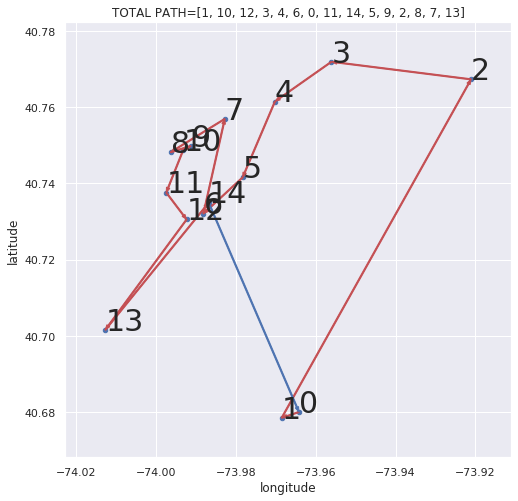

In [36]:
chromosomes[0][0].Plot()

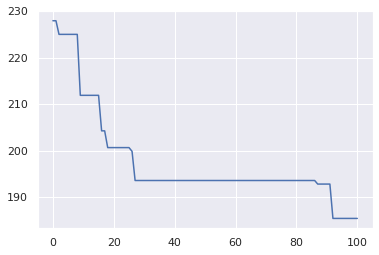

In [37]:
plt.plot(results)